In [1]:
import sys,os,glob
import subprocess

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.colors import LogNorm,Normalize,SymLogNorm
import matplotlib.gridspec as gridspec

import pandas as pd
import xarray as xr

import astropy.constants as ac
import astropy.units as au

from IPython import get_ipython
ipython = get_ipython()

# If in ipython, load autoreload extension
if 'ipython' in globals():
    ipython.magic('load_ext autoreload')
    ipython.magic('autoreload 2')

# Display all cell outputs in notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

In [2]:
plt.rcParams['figure.dpi']=200
plt.rcParams['mathtext.fontset']='cm'
plt.rcParams['font.size']=16

In [3]:
import pyathena as pa
coolftn=pa.coolftn()
units=pa.set_units(muH=1.4271)
to_Myr=units['time'].to('Myr').value
to_Msun=units['mass'].to('Msun').value
to_uG=units['magnetic_field'].value
to_pok=units['pressure'].cgs.value/ac.k_B.cgs.value
to_T1=(units['pressure']/units['density']*ac.m_p/ac.k_B).cgs.value

eta_conv=(ac.M_sun/ac.kpc**2/au.yr*au.km/au.s/ac.k_B).cgs.value

In [4]:
class vizdata(object):
    def __init__(self,pid,itime,base='/tigress/changgoo/',pdir=None,vtkdir=None,Omega=0.028):

        if pdir is None:
            pdir=pid
        if vtkdir is None:
            vtkdir=base+pdir
        self.pid=pid
        self.pdir=pdir+'/'
        self.base=base
        self.vtkdir=vtkdir
        self.itime=itime
        self.par=pa.get_params('{}{}/{}.par'.format(base,pdir,pid))
        if 'Omega' in self.par:
            self.Omega=self.par['Omega']
        else:
            self.Omega=Omega
        self.torb=2*np.pi/self.Omega

    def readhst(self):
        pid=self.pid
        pdir=self.pdir
        base=self.base
        itime=self.itime
        self.hst=pd.read_pickle('{}{}/hst/{}.hst.p'.format(base,pdir,pid))
        self.hzp=pd.read_pickle('{}{}/hst/{}.hst_zp.p'.format(base,pdir,pid))
        self.sn=pd.read_pickle('{}{}/hst/{}.sn.p'.format(base,pdir,pid))

    def readall(self):
        pid=self.pid
        pdir=self.pdir
        base=self.base
        itime=self.itime
        
        self.readhst()
        self.ds=pa.AthenaDataSet('{}/id0/{}.{:04d}.vtk'.format(self.vtkdir,pid,itime))
        self.sp=pa.read_starvtk('{}{}/starpar/{}.{:04d}.starpar.vtk'.format(base,pdir,pid,itime))
        self.slc=pd.read_pickle('{}{}/slice/{}.{:04d}.slice.p'.format(base,pdir,pid,itime))
        self.surf=pd.read_pickle('{}{}/surf/{}.{:04d}.surf.p'.format(base,pdir,pid,itime))
        
        dm=self.ds.domain
        self.yoffset=-np.mod(dm['time']*self.Omega*dm['Lx'][0],dm['Lx'][1])
        self.joffset=int(self.yoffset/dm['dx'][1])

In [5]:
def draw_pdf(pdf,**kwargs):

    dx=pdf[1][1]-pdf[1][0]
    dy=pdf[2][1]-pdf[2][0]
    norm_factor=pdf[0].sum()*dx*dy
    im=plt.imshow(pdf[0].T/norm_factor,origin='lower',
               extent=[pdf[1].min(),pdf[1].max(),pdf[2].min(),pdf[2].max()],**kwargs)
    return im

def plot_nP(xf,yf,hr=1.0,range=[[-5,3],[1,7]],wf=None,save=False,ref_hzp=None):
    def equilibrium(hr):
        coolftn=pa.coolftn()
        T1=np.logspace(1,4,100)
        Teq=coolftn.get_temp(T1)[::-1]
        neq=hr*2.e-26/coolftn.get_cool(T1)[::-1]

        neq_intp=np.logspace(-2,4,100)
        Peq_intp=np.interp(neq_intp,neq,1.1*neq*Teq)
        return neq_intp,Peq_intp
    
    fig=plt.figure(figsize=(8,6),num=0)
    
    ax=plt.subplot(111)
    plt.sca(ax)
    
    xdata=np.log10(xf)
    ydata=np.log10(yf)
    if wf is not None: 
        wdata=wf
    else:
        wdata=None
    nP_mpdf=np.histogram2d(xdata,ydata,bins=128,range=range,weights=wdata)
    im=draw_pdf(nP_mpdf,norm=LogNorm(),cmap=plt.cm.inferno)
    im.set_clim(1.e-4,10)
    ax.set_aspect('auto')
    plt.ylim(2,6)
    plt.xlim(-5,3)
    plt.ylabel(r'$\log\,P/k_B\,[\rm cm^{-3}\,K]$')
    plt.xlabel(r'$\log\,n_H\,[\rm cm^{-3}]$')    
    
    x,y=np.log10(equilibrium(hr))
    l,=plt.plot(x,y)

    return fig,im

In [6]:
sim=vizdata('R8_4pc_newacc',300)
sim.readall()

In [7]:
print(sim.ds.domain['time'])

300.0002


# n-P at z=0 

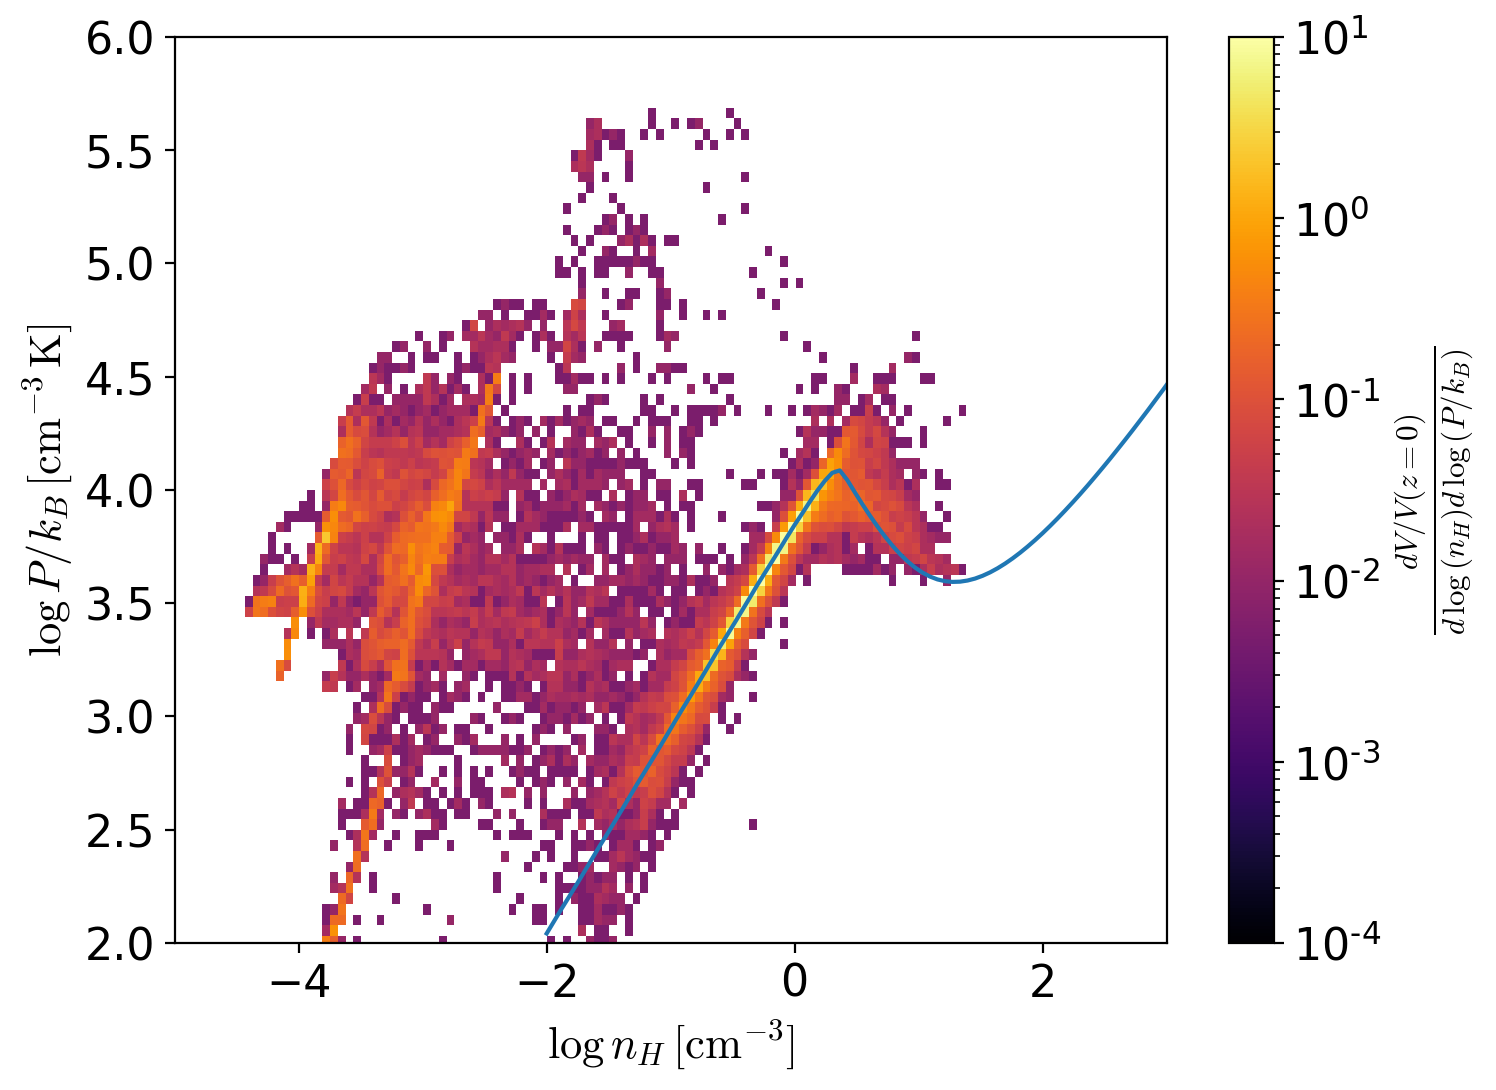

In [8]:
hr=np.interp(sim.ds.domain['time'],sim.hzp.index,sim.hzp['heat_ratio_hst'])
xf=sim.slc['z']['nH'].flatten()
yf=sim.slc['z']['pok'].flatten()

fig,im=plot_nP(xf,yf,hr=hr)
cbar=plt.colorbar(im,label=r'$\frac{dV/V(z=0)}{d\,\log\,(n_H) d\,\log\,(P/k_B)}$')

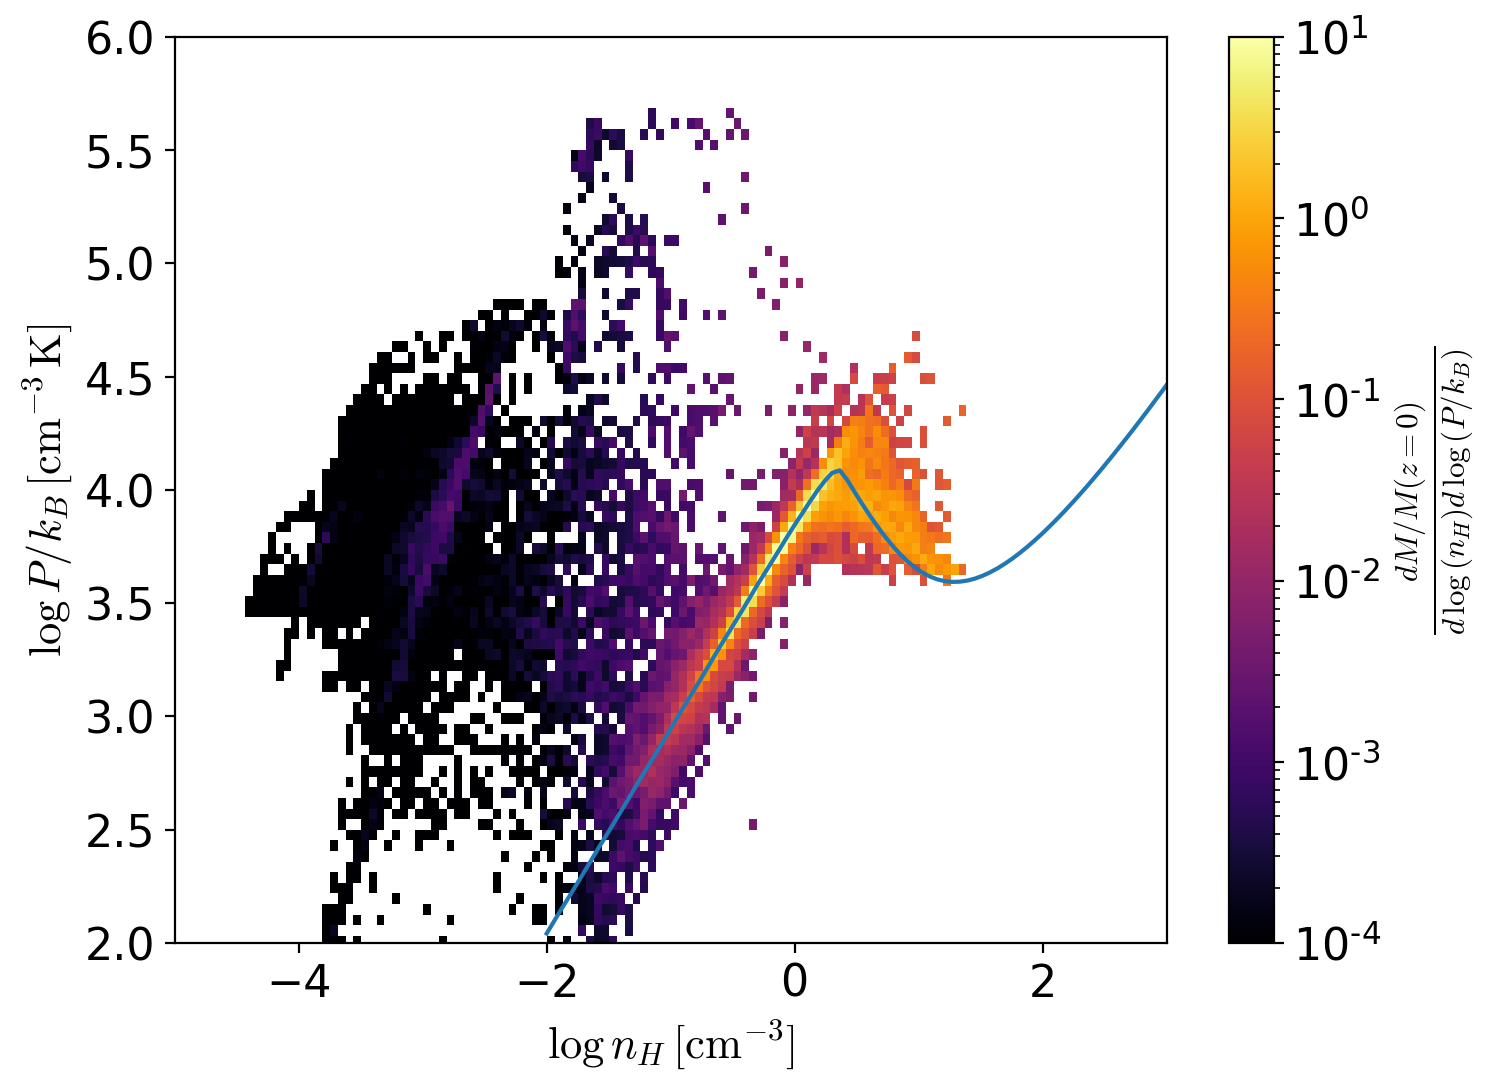

In [9]:
hr=np.interp(sim.ds.domain['time'],sim.hzp.index,sim.hzp['heat_ratio_hst'])
xf=sim.slc['z']['nH'].flatten()
yf=sim.slc['z']['pok'].flatten()

fig,im=plot_nP(xf,yf,hr=hr,wf=xf)
plt.colorbar(im,label=r'$\frac{dM/M(z=0)}{d\,\log\,(n_H) d\,\log\,(P/k_B)}$')

# n-P at z<H

In [13]:
den=sim.ds.read_all_data('density')
P=sim.ds.read_all_data('pressure')

H2p=np.interp(sim.ds.domain['time'],sim.hzp.index,sim.hzp['H_2p'])

x,y,z=pa.cc_arr(sim.ds.domain)

zidx=np.abs(z)<H2p # you can use any arbitrary value for somewhat thinner slice 

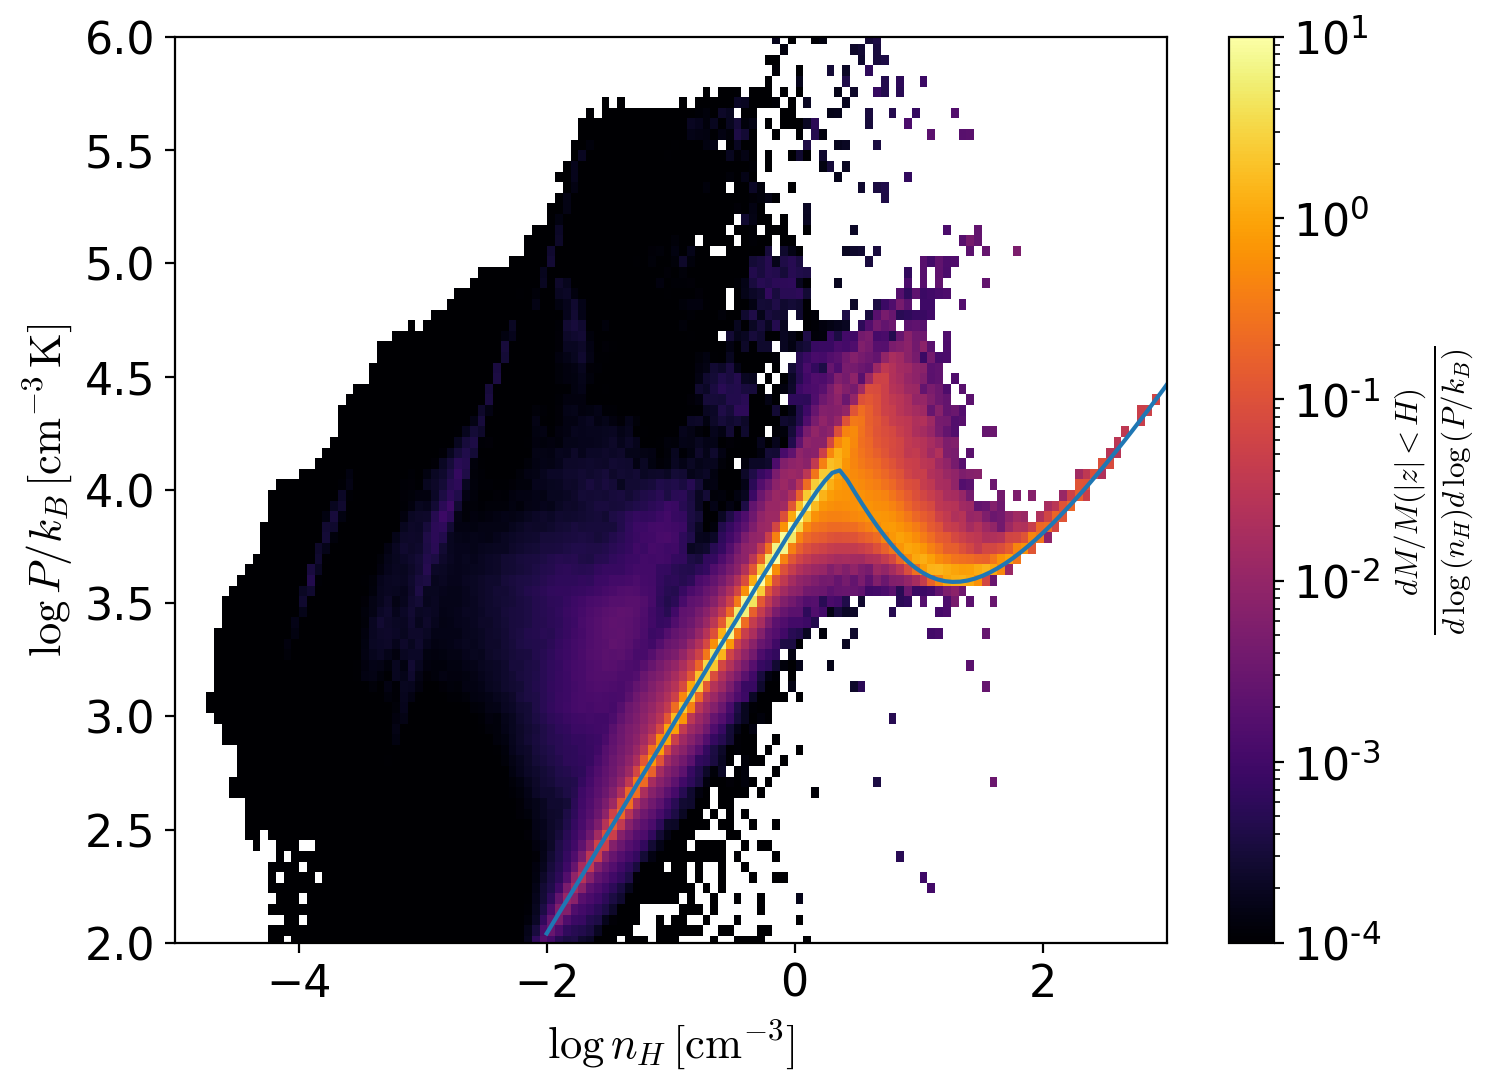

In [11]:
hr=np.interp(sim.ds.domain['time'],sim.hzp.index,sim.hzp['heat_ratio_hst'])
xf=den[zidx,:,:].flatten()
yf=(P[zidx,:,:]*to_pok).flatten()

fig=plot_nP(xf,yf,hr=hr,wf=xf)
plt.colorbar(im,label=r'$\frac{dM/M(|z|<H)}{d\,\log\,(n_H) d\,\log\,(P/k_B)}$')

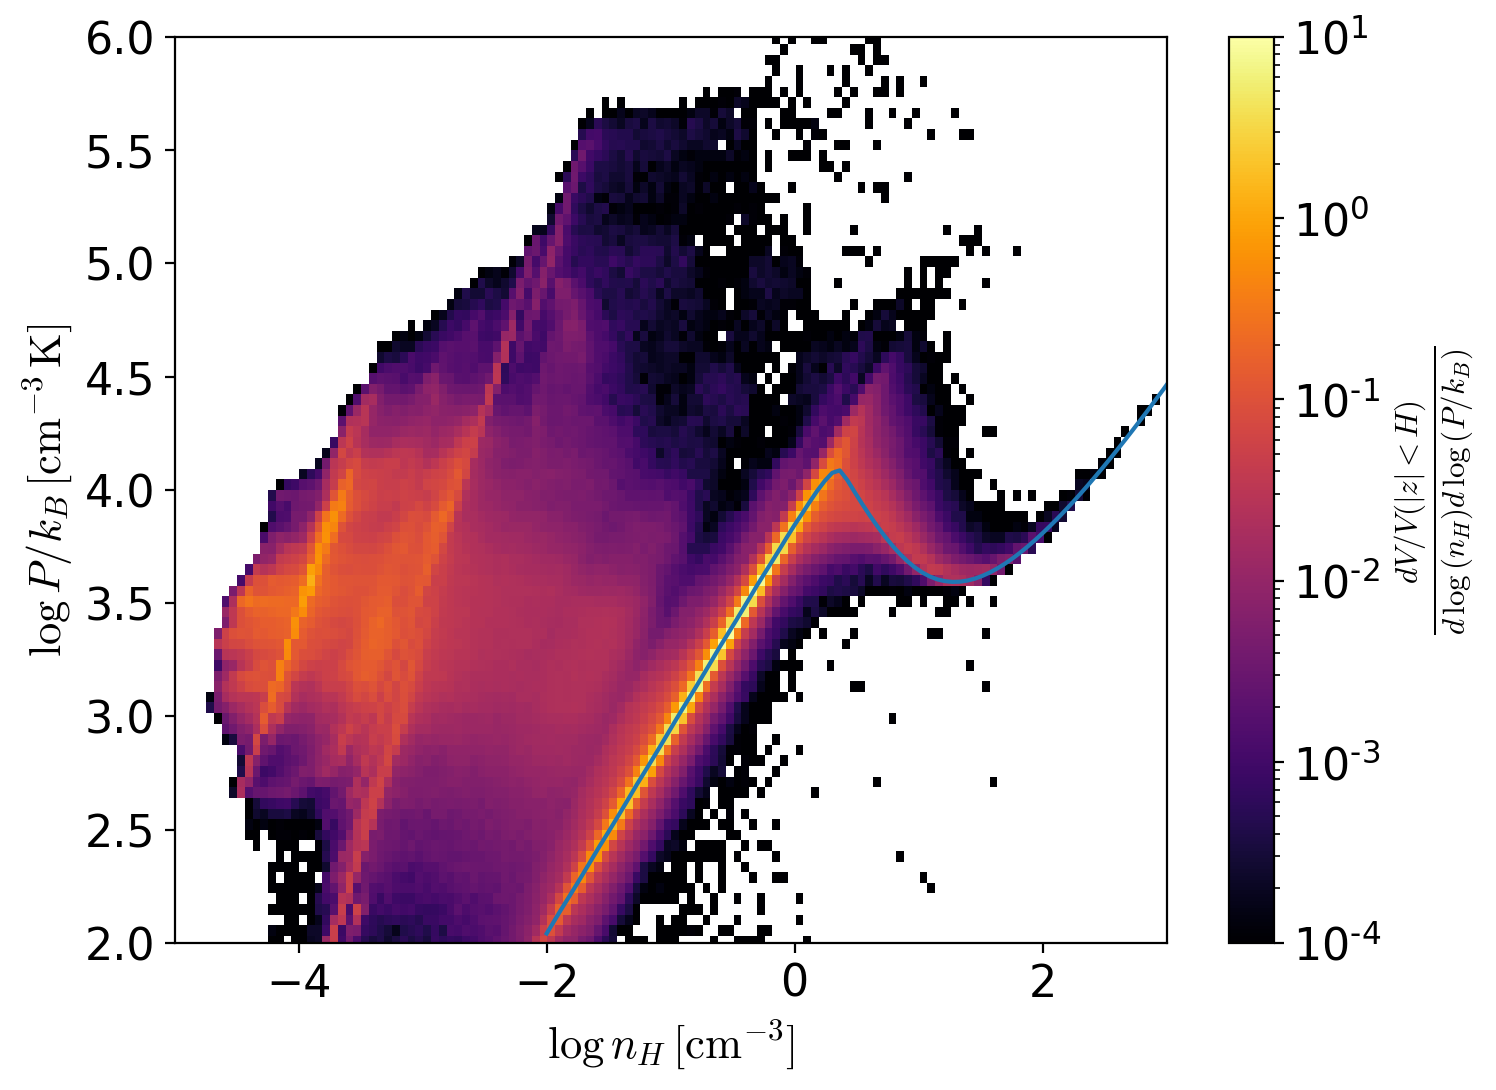

In [12]:
hr=np.interp(sim.ds.domain['time'],sim.hzp.index,sim.hzp['heat_ratio_hst'])
xf=den[zidx,:,:].flatten()
yf=(P[zidx,:,:]*to_pok).flatten()

fig=plot_nP(xf,yf,hr=hr)
plt.colorbar(im,label=r'$\frac{dV/V(|z|<H)}{d\,\log\,(n_H) d\,\log\,(P/k_B)}$')